In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from tqdm import tqdm, tqdm_notebook

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *

In [2]:
print(os.listdir("../input/"))

['test', 'train', 'train.csv', 'sample_submission.csv']


## Read and set up data

In [3]:
# Read data
train_dir = "../input/train/train/"
test_dir = "../input/test/test/"

train_df = pd.read_csv('../input/train.csv')
train_df.head()

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


Image shape = (32, 32, 3)


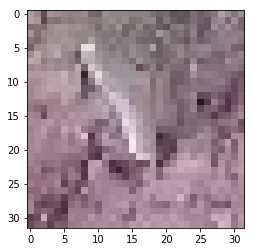

In [4]:
# Read and display an image
image = plt.imread(os.path.join(train_dir, os.listdir(train_dir)[0]))
print("Image shape =", image.shape)
plt.imshow(image)
plt.show()

In [5]:
# Setup training data
X_train, y_train = [], []

# List all training image file names
image_ids = train_df['id'].values

# Read each image and store in a list
for image_id in tqdm_notebook(image_ids):
    image = plt.imread(os.path.join(train_dir, image_id))
    X_train.append(image)

# Convert the list into array and set datatype to float32
X_train = np.asarray(X_train).astype('float32')
X_train /= 255.
print("X_train.shape =", X_train.shape)

# Read labels/y/has_cactus
y_train = train_df['has_cactus'].values
y_train = np.asarray(y_train).astype('float32')
print("y_train.shape =", y_train.shape)


X_train.shape = (17500, 32, 32, 3)
y_train.shape = (17500,)


In [6]:
# Set the shapes
train_m = X_train.shape[0]
train_input_shape = X_train.shape[1:]
train_input_shape

(32, 32, 3)

## Build model

In [7]:
# Load pre-trained model
vgg19_net = VGG19(weights=None, include_top=False, pooling='max',
                  input_shape=train_input_shape)

for layer in vgg19_net.layers:
    layer.trainable = True

vgg19_net.summay()

Instructions for updating:
Colocations handled automatically by placer.


AttributeError: 'Model' object has no attribute 'summay'

In [8]:
# Add layers at the end
X = vgg19_net.output
X = Flatten()(X)

X = Dropout(0.5)(X)
X = Dense(256, kernel_initializer='he_uniform')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

X = Dropout(0.5)(X)
X = Dense(512, kernel_initializer='he_uniform')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

X = Dropout(0.5)(X)
X = Dense(16, kernel_initializer='he_uniform')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

output = Dense(1, activation='sigmoid')(X)

model = Model(inputs=vgg19_net.input, outputs=output)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [9]:
#model = Sequential()
#model.add(vgg19_net)
#model.add(Flatten())
#model.add(Dense(256, activation='relu'))
#model.add(Dropout(0.5))
#model.add(Dense(1, activation='sigmoid'))
#model.summary()

In [10]:
model.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=0.0001, epsilon=1e-8), 
              metrics=['accuracy'])

In [11]:
batch_size = 32
n_epoch = 100

early_stop = EarlyStopping(monitor='val_acc', patience=20, verbose=1, 
                           mode='auto', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, 
                              verbose=1, mode='auto')

In [12]:
%%time
history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=n_epoch,
                    validation_split=0.2,
                    shuffle=True,
                    verbose=1,
                    callbacks=[early_stop, reduce_lr]
                   )

Train on 14000 samples, validate on 3500 samples
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/100
14000/14000 [==============================] - 17s 1ms/sample - loss: 0.5436 - acc: 0.8245 - val_loss: 0.3704 - val_acc: 0.9186
Epoch 2/100
14000/14000 [==============================] - 14s 969us/sample - loss: 0.3400 - acc: 0.9501 - val_loss: 0.2573 - val_acc: 0.9789
Epoch 3/100
14000/14000 [==============================] - 14s 966us/sample - loss: 0.2659 - acc: 0.9633 - val_loss: 0.3727 - val_acc: 0.8066
Epoch 4/100
14000/14000 [==============================] - 14s 966us/sample - loss: 0.2114 - acc: 0.9719 - val_loss: 0.2619 - val_acc: 0.9146
Epoch 5/100
14000/14000 [==============================] - 14s 975us/sample - loss: 0.1659 - acc: 0.9794 - val_loss: 0.1425 - val_acc: 0.9760
Epoch 6/100
14000/14000 [==============================] - 14s 974us/sample - loss: 0.1304 - acc: 0.9835 - val_loss: 

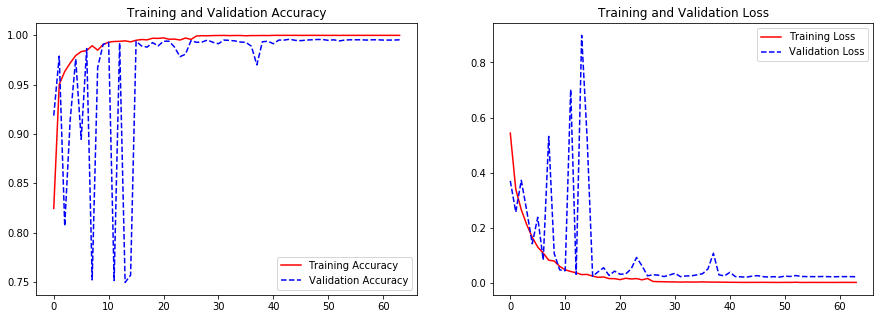

In [13]:
# Plot the training graph
def plot_training(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    fig, axes = plt.subplots(1, 2, figsize=(15,5))
    
    axes[0].plot(epochs, acc, 'r-', label='Training Accuracy')
    axes[0].plot(epochs, val_acc, 'b--', label='Validation Accuracy')
    axes[0].set_title('Training and Validation Accuracy')
    axes[0].legend(loc='best')

    axes[1].plot(epochs, loss, 'r-', label='Training Loss')
    axes[1].plot(epochs, val_loss, 'b--', label='Validation Loss')
    axes[1].set_title('Training and Validation Loss')
    axes[1].legend(loc='best')
    
    plt.show()
    
plot_training(history)

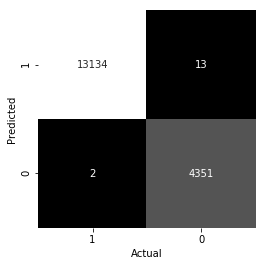

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4364
           1       1.00      1.00      1.00     13136

   micro avg       1.00      1.00      1.00     17500
   macro avg       1.00      1.00      1.00     17500
weighted avg       1.00      1.00      1.00     17500


AUC:  0.9984344141134807


In [14]:
# Classification report and confusion matrix
from sklearn.metrics import *
import seaborn as sns

def showClassficationReport(model, X_train, y_train):
    y_pred = model.predict(X_train)
    y_pred = y_pred >= 0.5
    y_pred = y_pred.astype('int').ravel()
    conf_matrix = confusion_matrix(y_train, y_pred, labels = [1,0])
    sns.heatmap(conf_matrix.T, annot=True, fmt="d", square=True, cbar=False, 
                cmap=plt.cm.gray, xticklabels=[1,0], yticklabels=[1,0])
    plt.ylabel('Predicted')
    plt.xlabel('Actual')
    plt.show()
    
    print(classification_report(y_train, y_pred, target_names=['0','1']))
    print("\nAUC: ", roc_auc_score(y_train, y_pred))

showClassficationReport(model, X_train, y_train)

## Prepare data for prediction on test set

In [15]:
# Setup training data
X_test = []
test_img_ids = []

# Read each image and store in a list
for image_id in os.listdir(test_dir):
    image = plt.imread(os.path.join(test_dir, image_id))
    X_test.append(image)
    test_img_ids.append(image_id)

# Convert the list into array and set datatype to float32
X_test = np.asarray(X_test).astype('float32')
X_test /= 255.
print("X_test.shape =", X_test.shape)
print("test_img_ids.shape =", len(test_img_ids))

X_test.shape = (4000, 32, 32, 3)
test_img_ids.shape = 4000


## Predict and Submit

In [16]:
# Predict on test data
predictions = model.predict(X_test)
predictions = predictions >= 0.5
predictions = predictions.astype('int').ravel()
predictions.shape

(4000,)

In [17]:
# Create dataframe for submission
submission_df = pd.DataFrame({'id' : test_img_ids,
                              'has_cactus' : predictions })
#submission_df['has_cactus'] = submission_df['has_cactus'].astype('int')
submission_df.head()

,id,has_cactus
0,c662bde123f0f83b3caae0ffda237a93.jpg,1
1,9553eed7793d4cf88b5226d446d93dae.jpg,0
2,19f059a7ce41b25be1548bc4049b45ec.jpg,1
3,fb4f464486f4894330273346ce939252.jpg,1
4,b52558a522db6ec2501ae188b6d6e526.jpg,0


In [18]:
# Create submission file
submission_df.to_csv('submission.csv', index=False)